In [31]:
import numpy as np
from spectral_clustering import spectral_clustering
import functions_for_plotting
from asymmetric_laplacian_distribution import get_index_per_class, get_labels, labels_to_layout_mapping
from sklearn.cluster import KMeans
import training_set_split
import seaborn as sns
import prediction_strength
import importlib
import matplotlib.pyplot as plt
from prediction_strength import get_F1_score_per_k
from matplotlib.legend import Legend
from training_set_split import get_training_folds

In [6]:
data_dir = "data/raw_data/daily_spontanous_dense/day20/"
day20_data = np.load(data_dir + "data_burst_by_time_day_20.npy").T

In [8]:
day20_data.shape

(13906, 3411)

In [10]:
noise_dict = ""#"Noise_Analysis/F1_scores/Ambiguous_Noise=[0,0.2]/"#"Noise_Analysis/F1_scores/Cleary_Seperable_Noise=[0,1]/"

In [137]:
folds = 5
condition = "5_fold_random"
reg = "0.01"

In [138]:
f1_score_fold_files = []

for i in range(1,folds+1):
    f1_score_files_i = []
    
    #f1_score_files_i.append(noise_dict + "F1_ambig_equal_noise=[0,0.2]_Euclidean_k=10_reg=None_%s_%d_100clusters_true.npy" % (condition,i))
    f1_score_files_i.append(noise_dict + "F1_day20_Euclidean_k=10_reg=%s_%s_%d_100clusters.npy" % (reg,condition,i))
    #f1_score_files_i.append(noise_dict + "F1_ambig_equal_noise=[0,0.2]_Euclidean_k=10_reg=None_%s_%d_100clusters_clusterwise_true.npy" % (condition,i))
    f1_score_files_i.append(noise_dict + "F1_day20_Euclidean_k=10_reg=%s_%s_%d_100clusters_clusterwise.npy" % (reg,condition,i))
    
    #f1_score_files_i.append(noise_dict + "F1_ambig_equal_noise=[0,0.2]_Euclidean_k=10_reg=None_%s_%d_clear_clusters_100clusters_true.npy" % (condition,i))
    #f1_score_files_i.append(noise_dict + "F1_ambig_equal_noise=[0,0.2]_Euclidean_k=10_reg=None_%s_%d_clear_clusters_100clusters.npy" % (condition,i))
    #f1_score_files_i.append(noise_dict + "F1_ambig_equal_noise=[0,0.2]_Euclidean_k=10_reg=None_%s_%d_clear_clusters_100clusters_clusterwise_true.npy" % (condition,i))
    #f1_score_files_i.append(noise_dict + "F1_ambig_equal_noise=[0,0.2]_Euclidean_k=10_reg=None_%s_%d_clear_clusters_100clusters_clusterwise.npy" % (condition,i))
    
    f1_score_fold_files.append(f1_score_files_i)

In [95]:
#f1_score_files = ["F1_ambig_equal_noise=[0,0.2]_Euclidean_k=10_reg=None_clear_clusters_true.npy", "F1_ambig_equal_noise=[0,0.2]_Euclidean_k=10_reg=None_true.npy",
#                "Noise_Analysis/F1_scores/Ambiguous_Noise=[0,0.2]/F1_k=10_ambig_equal_noise=[0,0.2]_Euclidean_reg=None_clear_clusters.npy" , "Noise_Analysis/F1_scores/Ambiguous_Noise=[0,0.2]/F1_k=10_ambig_equal_noise=[0,0.2]_Euclidean_reg=None.npy"]

#f1_score_files = ["F1_ambig_equal_noise=[0,0.2]_SSIM_RAW_k=10_reg=None_weighting=True_clear_clusters_true.npy", "F1_ambig_equal_noise=[0,0.2]_SSIM_RAW_k=10_reg=None_weighting=True_true.npy",
#                "Noise_Analysis/F1_scores/Ambiguous_Noise=[0,0.2]/F1_k=10_ambig_equal_noise=[0,0.2]_SSIM_RAW_clear_clusters.npy" , "Noise_Analysis/F1_scores/Ambiguous_Noise=[0,0.2]/F1_k=10_ambig_equal_noise=[0,0.2]_SSIM_RAW.npy"]


f1_score_fold_files = [["F1_clear_equal_noise=[0,0.2]_Euclidean_k=10_reg=None_true.npy", 
                        "F1_clear_equal_noise=[0,0.2]_Euclidean_k=10_reg=None_clusterwise_true.npy",
                        #"F1_ambig_equal_noise=[0,0.2]_Euclidean_k=10_reg=None_clear_clusters_true.npy", 
                        #"F1_ambig_equal_noise=[0,0.2]_Euclidean_k=10_reg=None_clear_clusters_clusterwise_true.npy"
                       ]]


In [67]:
#keys = ["Fold%d" % i for i in range(1,3)]

In [139]:
keys = [#"All Clusters (True Labels)",
        "All Clusters (Clustered Training Centroids)",
        #"Clear Clusters (True Labels)",   
        #"Clear Clusters (Clustered Training Centroids)",
        #"Clusterwise Mean (True Labels)", 
        #"Clusterwise Min (True Labels)",
        "Clusterwise Mean (Clustered Training Labels)", 
        "Clusterwise Min (Clustered Training Labels)",
        #"Clear Clusters Clusterwise Mean (True Labels)",
        #"Clear Clusters Clusterwise Min (True Labels)",
        #"Clear Clusters Clusterwise Mean (Clustered Training Labels)",
        #"Clear Clusters Clusterwise Min (Clustered Training Labels)"
       ]

In [113]:
#keys = ["Fold1 (3 clusters missing but all present in training)", "Fold2 (all clusters present but 3 missing in training)"]

In [5]:
#keys = ["Clustered Training Centroids", "True Labels"]#,"True Training Centroids"]
#keys = ["Clusterwise Mean (Clustered Training Centroids)", "Clusterwise Min (Clustered Training Centroids)", "Clusterwise Mean (True Labels)", "Clusterwise Min (True Labels)"]

In [140]:
clusterwise = False
F1_scores_fold_configuration_true = []
F1_scores_fold_configuration = []
F1_scores_fold_configuration_clusterwise_true = []
F1_scores_fold_configuration_clusterwise = []

for i,scores in enumerate(f1_score_fold_files):  
    F1_scores_configuration_true_i = []
    F1_scores_configuration_i = []
    F1_scores_fold_configuration_clusterwise_true_i = []
    F1_scores_fold_configuration_clusterwise_i = []
    
    for f,file in enumerate(scores): 
        f1_dict = np.load(file,allow_pickle=True).item()
        k_clusters = np.sort(list(f1_dict.keys()))
        F1_scores = []
        F1_scores_clusterwise_mean = []
        F1_scores_clusterwise_min = []
        
        for k in k_clusters:
            #mean_prediction_strengths.append(np.mean(prediction_strengths_per_k[k]))
            #err_prediction_strengths.append(np.std(prediction_strengths_per_k[k]))
            #min_prediction_strengths.append(np.amin(prediction_strengths_per_k[k]))
            if "clusterwise" in file:
                    F1_scores_clusterwise_mean.append(np.mean(f1_dict[k]))
                    F1_scores_clusterwise_min.append(np.amin(f1_dict[k]))
            else:
                F1_scores.append(f1_dict[k])
        
        if len(F1_scores_clusterwise_mean) > 0:
            #if "fold" in file:
            elementwise_combined = [[x,y] for x,y in zip(F1_scores_clusterwise_mean, F1_scores_clusterwise_min)]
            if "true" in file:
                F1_scores_fold_configuration_clusterwise_true_i.append(elementwise_combined)
            else:
                F1_scores_fold_configuration_clusterwise_i.append(elementwise_combined)
            #else:
            #    F1_scores_configuration_i.append(F1_scores_clusterwise_mean)
            #    F1_scores_configuration_i.append(F1_scores_clusterwise_min)
        else:
            if "true" in file:
                F1_scores_configuration_true_i.append(F1_scores)
            else:
                F1_scores_configuration_i.append(F1_scores)
    
    
    F1_scores_fold_configuration_true.append(F1_scores_configuration_true_i)
    F1_scores_fold_configuration.append(F1_scores_configuration_i)
    F1_scores_fold_configuration_clusterwise_true.append(F1_scores_fold_configuration_clusterwise_true_i)
    F1_scores_fold_configuration_clusterwise.append(F1_scores_fold_configuration_clusterwise_i)

In [141]:
mean_f1_scores = []
std_f1_scores = []

if np.sum(F1_scores_fold_configuration_true) >0:
    mean_fold_f1_scores_true = np.mean(F1_scores_fold_configuration_true, axis = 0)
    std_fold_f1_scores_true = np.std(F1_scores_fold_configuration_true, axis = 0)
#else:
#    mean_fold_f1_scores_true = []
#    std_fold_f1_scores_true = []
    
    #mean_f1_scores.(mean_fold_f1_scores_true)
    #std_f1_scores.append(std_fold_f1_scores_true)
    mean_f1_scores += list(mean_fold_f1_scores_true)
    std_f1_scores += list(std_fold_f1_scores_true)


if np.sum(F1_scores_fold_configuration) >0:
    mean_fold_f1_scores = np.mean(F1_scores_fold_configuration, axis = 0)
    std_fold_f1_scores = np.std(F1_scores_fold_configuration, axis = 0)

#else:
#    mean_fold_f1_scores = []
#    std_fold_f1_scores = []
    
    #mean_f1_scores.append(mean_fold_f1_scores)
    #std_f1_scores.append(std_fold_f1_scores)
    mean_f1_scores += list(mean_fold_f1_scores)
    std_f1_scores += list(std_fold_f1_scores)


if np.sum(F1_scores_fold_configuration_clusterwise_true) > 0:
    mean_fold_f1_scores_clusterwise_true = np.mean(np.asarray(F1_scores_fold_configuration_clusterwise_true)[:,:,:,0], axis = 0)
    std_fold_f1_scores_clusterwise_true = np.std(np.asarray(F1_scores_fold_configuration_clusterwise_true)[:,:,:,0], axis = 0)
    
    mean_min_fold_f1_scores_clusterwise_true = np.mean(np.asarray(F1_scores_fold_configuration_clusterwise_true)[:,:,:,1], axis = 0)
    std_min_fold_f1_scores_clusterwise_true = np.std(np.asarray(F1_scores_fold_configuration_clusterwise_true)[:,:,:,1], axis = 0)

#else:
#    mean_fold_f1_scores_clusterwise_true = []
#    std_fold_f1_scores_clusterwise_true = []
#    
#    mean_min_fold_f1_scores_clusterwise_true = []
#    std_min_fold_f1_scores_clusterwise_true = []

    #mean_f1_scores.append(mean_fold_f1_scores_clusterwise_true)
    #std_f1_scores.append(std_fold_f1_scores_clusterwise_true)  
    mean_f1_scores+= list(mean_fold_f1_scores_clusterwise_true)
    std_f1_scores+= list(std_fold_f1_scores_clusterwise_true)  
    
    #mean_f1_scores.append(mean_min_fold_f1_scores_clusterwise_true)
    #std_f1_scores.append(std_min_fold_f1_scores_clusterwise_true)
    mean_f1_scores+=list(mean_min_fold_f1_scores_clusterwise_true)
    std_f1_scores+=list(std_min_fold_f1_scores_clusterwise_true) 
    
    
if np.sum(F1_scores_fold_configuration_clusterwise)>0:
    mean_fold_f1_scores_clusterwise = np.mean(np.asarray(F1_scores_fold_configuration_clusterwise)[:,:,:,0], axis = 0)
    std_fold_f1_scores_clusterwise = np.std(np.asarray(F1_scores_fold_configuration_clusterwise)[:,:,:,0], axis = 0)
    
    mean_min_fold_f1_scores_clusterwise = np.mean(np.asarray(F1_scores_fold_configuration_clusterwise)[:,:,:,1], axis = 0)
    std_min_fold_f1_scores_clusterwise = np.std(np.asarray(F1_scores_fold_configuration_clusterwise)[:,:,:,1], axis = 0)
    
#else:
#    mean_fold_f1_scores_clusterwise = []
#    std_fold_f1_scores_clusterwise = []
    
#    mean_min_fold_f1_scores_clusterwise = []
#    std_min_fold_f1_scores_clusterwise = []
    
    #mean_f1_scores.append(mean_fold_f1_scores_clusterwise)
    #std_f1_scores.append(std_fold_f1_scores_clusterwise)  
    mean_f1_scores+=list(mean_fold_f1_scores_clusterwise)
    std_f1_scores+=list(std_fold_f1_scores_clusterwise)  
    
    #mean_f1_scores.append(mean_min_fold_f1_scores_clusterwise)
    #std_f1_scores.append(std_min_fold_f1_scores_clusterwise) 
    mean_f1_scores+=list(mean_min_fold_f1_scores_clusterwise)
    std_f1_scores+=list(std_min_fold_f1_scores_clusterwise) 

# Mean F1 - Scores

In [142]:
figsize=(20,10)
plot_adjustments = [0.05,0.08,0.95, 0.91]
save_file = "F1_Euclidean_k=10_reg=0.01_5_fold_random_100clusters.pdf"
title = "F1 scores of clusters found in a 5 fold random split of day 20 \n reg=0.01"  
clusterwise=False

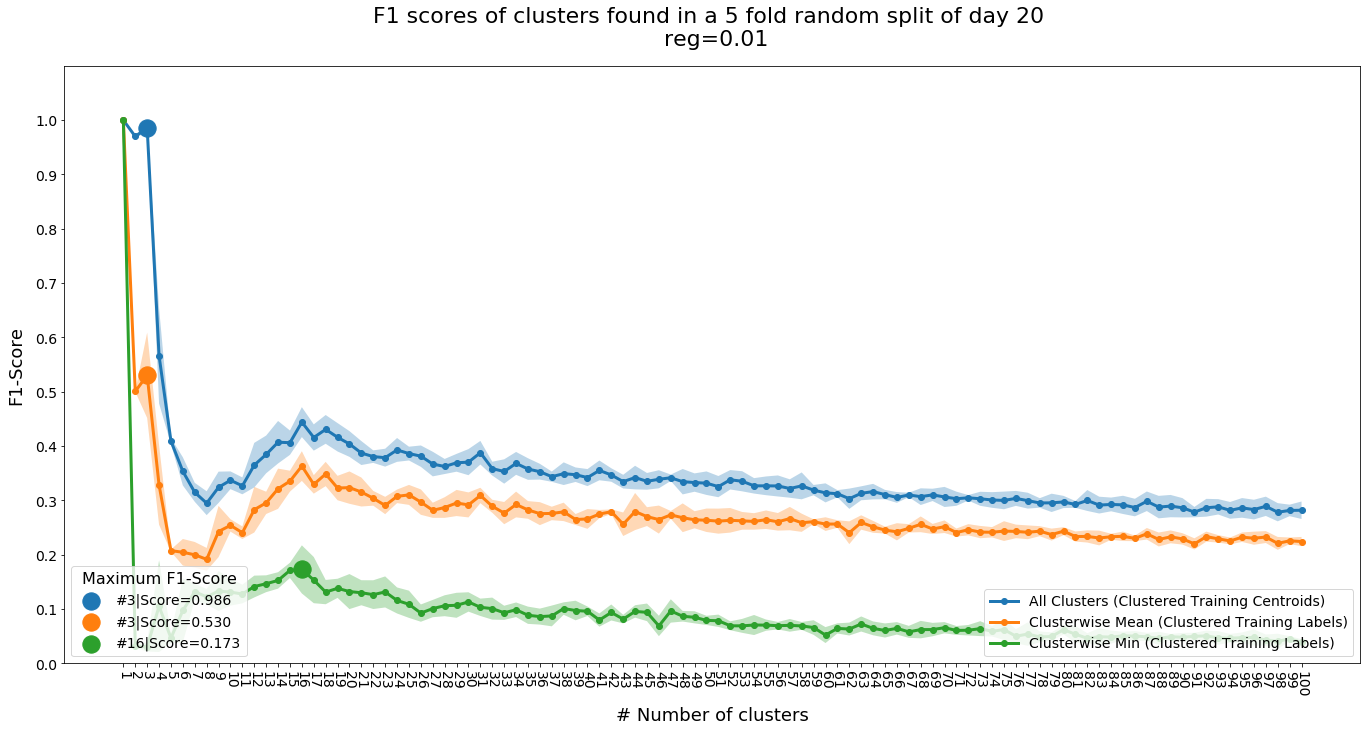

In [143]:
fig, ax = plt.subplots(figsize=figsize)
k_clusters = range(1,101)

f1_lines = []
f1_max_points = []
f1_max_points_labels = []
for i,key in enumerate(keys):
    #if clusterwise:
    #    j = i%2
    #    F1_scores = mean_fold_f1_scores[int(i>1)][:,j]
    #    F1_scores_std = std_fold_f1_scores[int(i>1)][:,j]
    #    argmax_f1 = np.argmax(F1_scores[1:]) + 1
    #else:
    #    F1_scores = mean_fold_f1_scores[i]
    #    F1_scores_std = std_fold_f1_scores[i]
    #    argmax_f1 = np.argmax(F1_scores[1:]) + 1
    F1_scores = mean_f1_scores[i]#[0]
    F1_scores_std = std_f1_scores[i]#[0]
    argmax_f1 = np.argmax(F1_scores[1:]) + 1

    f1_lines += ax.plot(k_clusters, F1_scores, "o-", label=key, color = "C0%d" % i,linewidth=3)
    f1_max_points += [ax.scatter(k_clusters[argmax_f1], F1_scores[argmax_f1], color = "C0%d" % i, marker="o",s=300)]
    f1_max_points_labels +=  ["#%d|Score=%.3f" % (argmax_f1+1, F1_scores[argmax_f1])]
    plt.fill_between(k_clusters, F1_scores-F1_scores_std, F1_scores+F1_scores_std, alpha=.3)
    
    #ax.annotate("#%d|Score=%.3f" % (argmax_f1+1, F1_scores[argmax_f1]), (k_clusters[argmax_f1] - 1, F1_scores[argmax_f1] + 0.03 - i*0.03), fontsize=16, color = "C0%d" % i)


ax.set_title(title, fontsize=22, pad=20)
ax.set_xticks(k_clusters)
ax.set_xlabel("# Number of clusters", fontsize=18, labelpad=10)
ax.set_ylabel("F1-Score", fontsize=18, labelpad=10),
ax.set_ylim((0, 1.1))
ax.tick_params(axis='y',labelsize=14)
ax.tick_params(axis='x',labelsize=14,rotation=-90)

ax.set_yticks(np.arange(0, 1.1,0.1))
left = plot_adjustments[0]
bottom = plot_adjustments[1]
right = plot_adjustments[2]
top = plot_adjustments[3]

plt.subplots_adjust(left,bottom,right, top)

ax.legend(f1_lines, keys,fontsize = 14, loc="lower right")
leg = Legend(ax, f1_max_points,f1_max_points_labels,fontsize = 14, loc="lower left", title = "Maximum F1-Score", )
leg.get_title().set_fontsize('16')
ax.add_artist(leg)
#plt.savefig(save_file)

# Clusterwise Analysis

In [179]:
f1_scores_based_on_training_centroids=True
labels_dict = ""
threshold = 0.9
top_n = 10

In [95]:
train_fold_indices, valid_fold_indices = get_training_folds(day20_data,None, cluster_split = "random",folds = 5)

In [146]:
clustered_labels_folds_train = np.load(labels_dict+ "labels_day20_Euclidean_k=10_reg=0.01_5_fold_random_train_100clusters.npy",allow_pickle=True)
clustered_labels_folds_valid = np.load(labels_dict+ "labels_day20_Euclidean_k=10_reg=0.01_5_fold_random_valid_100clusters.npy",allow_pickle=True)

In [180]:
mean_clusterwise_folds = []
min_clusterwise_folds = []
mean_clusterwise_size_weighted_folds = []
#min_clusterwise_size_weighted_folds = []

clusters_above_threshold_folds = []
clusters_above_threshold_proportional_folds = []
clusters_above_threshold_size_folds = []

highest_nclusters_folds = []
mean_highest_nclusters_folds = []
min_highest_nclusters_folds = []
mean_highest_nclusters_size_weighted_folds = []
mean_highest_nclusters_proportional_weighted_folds = []
bursts_in_top_n_clusters_folds = []


bursts_from_clear_clusters_in_highest_n_folds = []
proportion_bursts_from_clear_clusters_in_highest_folds = []
bursts_form_clear_clusters_in_clusters_above_threshold_folds = []
proportion_bursts_form_clear_clusters_in_clusters_above_threshold_folds = []

for f in range(folds):    
    f1_dict = np.load(f1_score_fold_files[f][f1_scores_based_on_training_centroids],allow_pickle=True).item()
    mean_clusterwise = []
    min_clusterwise = []
    mean_clusterwise_size_weighted = []
    #min_clusterwise_size_weighted = []
   
    clusters_above_threshold = []
    clusters_above_threshold_proportional = []
    clusters_above_threshold_size = []
    
    highest_nclusters = []
    mean_highest_nclusters = []
    min_highest_nclusters = []
    mean_highest_nclusters_size_weighted = []
    bursts_in_top_n_clusters = []
    
    bursts_from_clear_clusters_in_highest_n = []
    proportion_bursts_from_clear_clusters_in_highest = []
    bursts_form_clear_clusters_in_clusters_above_threshold = []
    proportion_bursts_form_clear_clusters_in_clusters_above_threshold = []

    

    for i,clusters in enumerate(range(1,101)):
        scores = f1_dict[clusters]
        labels = clustered_labels_folds_valid[f][i]
        _, cluster_counts = np.unique(labels, return_counts=True)

    
        mean_weighted_scores = np.sum(scores*cluster_counts)/len(labels)  
        #min_weighted_scores = np.amin(scores*cluster_counts)/len(labels)  
        mean_score = np.mean(scores)
        min_score = np.amin(scores)
        
        clusters_above_threshold_i = len(np.where(scores>=threshold)[0])
        clusters_above_threshold_proportional_i = clusters_above_threshold_i/clusters
        clusters_above_threshold_size_i = np.sum(cluster_counts[np.where(scores>=threshold)])#/len(labels)
        clusters_above_threshold_proportional_and_size_i = clusters_above_threshold_proportional_i*np.sum(cluster_counts[np.where(scores>=threshold)])/len(valid_fold_indices[f])
        
        
        highest_nclusters_i = np.argsort(scores)[-top_n:]
        highest_nclusters_scores = np.sort(scores)[-top_n:]
        mean_highest_nclusters_score = np.mean(highest_nclusters_scores)
        min_highest_nclusters_score = np.amin(highest_nclusters_scores)
        mean_highest_nclusters_size_weighted_score = np.sum(highest_nclusters_scores*cluster_counts[highest_nclusters_i])/len(labels)#np.sum(cluster_counts[highest_nclusters_i])
        bursts_in_top_n_clusters_i = np.sum(cluster_counts[highest_nclusters_i])
        
        
        """
        bursts_from_clear_clusters_in_highest_n_i = []
        bursts_form_clear_clusters_in_clusters_above_threshold_i = []
        
        for c in highest_nclusters_i:
            bursts_in_c = valid_fold_indices[f][np.where(clustered_labels_folds_valid[f][i] == c)[0]]
            clear_bursts_in_c = np.where(np.isin(bursts_in_c,clear_indices_valid_folds[f]) == True)[0]
            bursts_from_clear_clusters_in_highest_n_i.append(clear_bursts_in_c)
         
        for c in np.where(scores>=threshold)[0]:
            bursts_in_c = valid_fold_indices[f][np.where(clustered_labels_folds_valid[f][i] == c)[0]]
            clear_bursts_in_c = np.where(np.isin(bursts_in_c,clear_indices_valid_folds[f]) == True)[0]
            bursts_form_clear_clusters_in_clusters_above_threshold_i.append(clear_bursts_in_c)
        """    
        """
        proportion_bursts_from_clear_clusters_in_highest_i = np.sum([len(x) for x in bursts_from_clear_clusters_in_highest_n_i])/clear_burst_in_valid_data[f]
        proportion_bursts_form_clear_clusters_in_clusters_above_threshold_i = np.sum([len(x) for x in bursts_form_clear_clusters_in_clusters_above_threshold_i])/clear_burst_in_valid_data[f]
        """
        
        mean_clusterwise.append(mean_score)
        min_clusterwise.append(min_score)
        mean_clusterwise_size_weighted.append(mean_weighted_scores)
        #min_clusterwise_size_weighted.append(min_weighted_scores)

        clusters_above_threshold.append(clusters_above_threshold_i)
        clusters_above_threshold_size.append(clusters_above_threshold_size_i)
        clusters_above_threshold_proportional.append(clusters_above_threshold_proportional_i)
        
        highest_nclusters.append([highest_nclusters_i,highest_nclusters_scores])
        mean_highest_nclusters.append(mean_highest_nclusters_score)
        min_highest_nclusters.append(min_highest_nclusters_score)
        mean_highest_nclusters_size_weighted.append(mean_highest_nclusters_size_weighted_score)
        bursts_in_top_n_clusters.append(bursts_in_top_n_clusters_i)
        
        
        #bursts_from_clear_clusters_in_highest_n.append(bursts_from_clear_clusters_in_highest_n_i)
        #bursts_form_clear_clusters_in_clusters_above_threshold.append(bursts_form_clear_clusters_in_clusters_above_threshold_i)
        #proportion_bursts_from_clear_clusters_in_highest.append(proportion_bursts_from_clear_clusters_in_highest_i)
        #proportion_bursts_form_clear_clusters_in_clusters_above_threshold.append(proportion_bursts_form_clear_clusters_in_clusters_above_threshold_i)
        
    mean_clusterwise_folds.append(mean_clusterwise)
    min_clusterwise_folds.append(min_clusterwise)
    mean_clusterwise_size_weighted_folds.append(mean_clusterwise_size_weighted)
    #min_clusterwise_size_weighted_folds.append(min_clusterwise_size_weighted)
    
    clusters_above_threshold_folds.append(clusters_above_threshold)
    clusters_above_threshold_proportional_folds.append(clusters_above_threshold_proportional)
    clusters_above_threshold_size_folds.append(clusters_above_threshold_size)
    

    highest_nclusters_folds.append(highest_nclusters)
    mean_highest_nclusters_folds.append(mean_highest_nclusters)
    min_highest_nclusters_folds.append(min_highest_nclusters)
    mean_highest_nclusters_size_weighted_folds.append(mean_highest_nclusters_size_weighted)
    bursts_in_top_n_clusters_folds.append(bursts_in_top_n_clusters)
       
    #bursts_from_clear_clusters_in_highest_n_folds.append(bursts_from_clear_clusters_in_highest_n)
    #bursts_form_clear_clusters_in_clusters_above_threshold_folds.append(bursts_form_clear_clusters_in_clusters_above_threshold)
    #proportion_bursts_from_clear_clusters_in_highest_folds.append(proportion_bursts_from_clear_clusters_in_highest)
    #proportion_bursts_form_clear_clusters_in_clusters_above_threshold_folds.append(proportion_bursts_form_clear_clusters_in_clusters_above_threshold)

In [169]:
t05 = [np.mean(np.asarray(clusters_above_threshold_proportional_folds),axis=0), np.std(np.asarray(clusters_above_threshold_proportional_folds),axis=0)]
#t05 = [np.mean(np.asarray(clusters_above_threshold_size_folds),axis=0), np.std(np.asarray(clusters_above_threshold_size_folds),axis=0)] 

In [172]:
t06 = [np.mean(np.asarray(clusters_above_threshold_proportional_folds),axis=0), np.std(np.asarray(clusters_above_threshold_proportional_folds),axis=0)]
#t06 = [np.mean(np.asarray(clusters_above_threshold_size_folds),axis=0), np.std(np.asarray(clusters_above_threshold_size_folds),axis=0)] 

In [175]:
t07 = [np.mean(np.asarray(clusters_above_threshold_proportional_folds),axis=0), np.std(np.asarray(clusters_above_threshold_proportional_folds),axis=0)]
#t07 = [np.mean(np.asarray(clusters_above_threshold_size_folds),axis=0), np.std(np.asarray(clusters_above_threshold_size_folds),axis=0)] 

In [178]:
t08 = [np.mean(np.asarray(clusters_above_threshold_proportional_folds),axis=0), np.std(np.asarray(clusters_above_threshold_proportional_folds),axis=0)]
#t08 = [np.mean(np.asarray(clusters_above_threshold_size_folds),axis=0), np.std(np.asarray(clusters_above_threshold_size_folds),axis=0)] 

In [181]:
t09 = [np.mean(np.asarray(clusters_above_threshold_proportional_folds),axis=0), np.std(np.asarray(clusters_above_threshold_proportional_folds),axis=0)]
#t09 = [np.mean(np.asarray(clusters_above_threshold_size_folds),axis=0), np.std(np.asarray(clusters_above_threshold_size_folds),axis=0)] 

In [185]:
figsize=(20,10)
plot_adjustments = [0.05,0.08,0.95, 0.91]
#save_file = "F1_day20_Euclidean_k=10_reg=0.01_5_fold_random_100clusters_bursts_above_threshold.pdf"
save_file = "F1_day20_Euclidean_k=10_reg=0.01_5_fold_random_100clusters_proportion_clusters_above_threshold.pdf"

In [183]:
score_dict = {
              #"Clusters Above Threshold = 0.9 (Normalized by number clusters)" : t09,
              #"Clusters Above Threshold = 0.8 (Normalized by number clusters)": t08,
              #"Clusters Above Threshold = 0.7 (Normalized by number clusters)": t07
              #"Clusters Above Threshold = 0.9": t09,
              #"Clusters Above Threshold = 0.8": t08,
              #"Clusters Above Threshold = 0.7": t07,
              #"Clusters Above Threshold =0.9 (Number of bursts normalized by validation set size)" : t09, 
              #"Clusters Above Threshold =0.8 (Number of bursts normalized by validation set size)" : t08,
              #"Clusters Above Threshold =0.7 (Number of bursts normalized by validation set size)" : t07, 
              #"Proportion of Clear Bursts in Custers above Threhold=0.9": t09,
              #"Proportion of Clear Bursts in Custers above Threhold=0.8": t08,
              #"Proportion of Clear Bursts in Custers above Threhold=0.7": t07,
              #"Proportion of Clear Bursts in highest 12 F1-Score Clusters": top12_clear_clusters,
                
              #"Bursts in Clusters above threshold=0.5": t05,
              #"Bursts in Clusters above threshold=0.6": t06,
              #"Bursts in Clusters above threshold=0.7": t07,
              #"Bursts in Clusters above threshold=0.8": t08,
              #"Bursts in Clusters above threshold=0.9": t09 
            
              "Proportion Clusters Above Threshold = 0.5": t05,
              "Proportion Clusters Above Threshold = 0.6": t06,
              "Proportion Clusters Above Threshold = 0.7": t07,  
              "Proportion Clusters Above Threshold = 0.8": t08,
              "Proportion Clusters Above Threshold = 0.9": t09
    
                
              #"Clusters Above Threshold": [np.mean(np.asarray(clusters_above_threshold_folds),axis=0), np.std(np.asarray(clusters_above_threshold_folds),axis=0)],
              #"Clusters Above Threshold (Normalized by number clusters)": [np.mean(np.asarray(clusters_above_threshold_proportional_folds),axis=0), np.std(np.asarray(clusters_above_threshold_proportional_folds),axis=0)],
              #"Proportion of Clear Bursts in highest 12 F1-Score Clusters": [np.mean(np.asarray(proportion_bursts_from_clear_clusters_in_highest_folds), axis=0)[11:], np.std(np.asarray(proportion_bursts_from_clear_clusters_in_highest_folds),axis=0)[11:]],
              #"Proportion of Clear Bursts in Custers above Threhold": [np.mean(np.asarray(proportion_bursts_form_clear_clusters_in_clusters_above_threshold_folds), axis=0)[11:], np.std(np.asarray(proportion_bursts_form_clear_clusters_in_clusters_above_threshold_folds),axis=0)[11:]],
              #"Clusters Above Threshold (Number of bursts normalized by validation set size)" :[np.mean(np.asarray(clusters_above_threshold_size_folds),axis=0), np.std(np.asarray(clusters_above_threshold_size_folds),axis=0)], 
              #"Clusters Above Threshold (Number of bursts normalized by validation set size and number clusters)" :[np.mean(np.asarray(clusters_above_threshold_proportional_and_size_folds),axis=0)[1:], np.std(np.asarray(clusters_above_threshold_proportional_and_size_folds),axis=0)[1:]] 
}
             

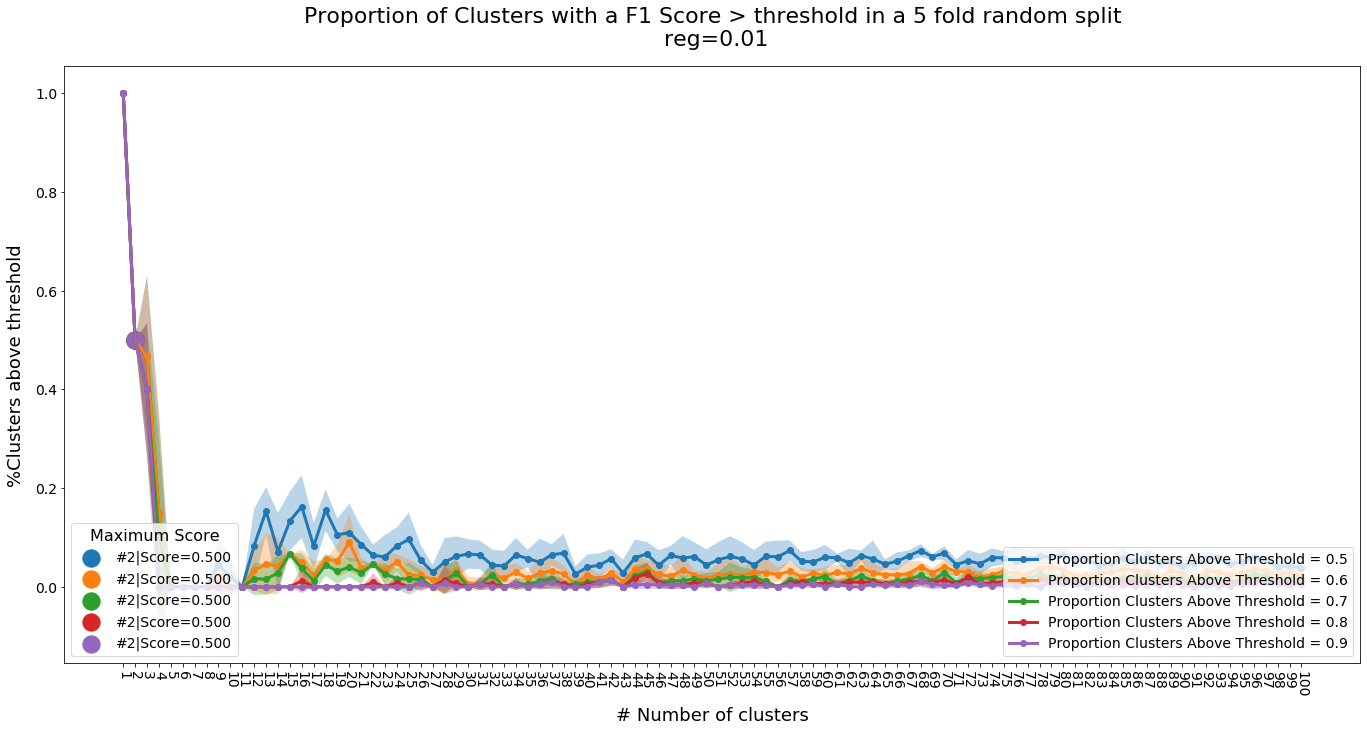

In [186]:
fig, ax = plt.subplots(figsize=figsize)
k_clusters = range(1,101)
#score_name = "F1-Score"
#score_name = "#Cluster above threshold=%.2f" % threshold
#score_name = "#Bursts in Clusters above threshold normalized by validation set size"
#score_name = "% of Clear Cluster Bursts in Clusters above threshold"
#score_name = "#Bursts in Clusters above threshold"
#score_name = "#Bursts in Clusters above threshold"
#title = "Number of Bursts in Clusters with a F1 Score > threshold in a 5 fold random split\n reg=0.01" 
score_name = "%Clusters above threshold"
title = "Proportion of Clusters with a F1 Score > threshold in a 5 fold random split\n reg=0.01" 

max_points_labels = []
max_points = []
lines = []

for i,key in enumerate(list(score_dict.keys())):
    mean_scores = score_dict[key][0]#np.mean(np.asarray(mean_clusterwise_folds),axis=0)
    std_scores = score_dict[key][1]#np.std(np.asarray(mean_clusterwise_folds),axis=0)
    argmax_scores = np.argmax(mean_scores[1:]) + 1

    lines += ax.plot(k_clusters, mean_scores, "o-", label=key, color = "C0%d" % i,linewidth=3)
    max_points += [ax.scatter(k_clusters[argmax_scores], mean_scores[argmax_scores], color = "C0%d" % i, marker="o",s=300)]
    max_points_labels +=  ["#%d|Score=%.3f" % (k_clusters[argmax_scores], mean_scores[argmax_scores])]
    plt.fill_between(k_clusters, mean_scores-std_scores, mean_scores+std_scores, alpha=.3)

#ax.annotate("#%d|Score=%.3f" % (argmax_f1+1, F1_scores[argmax_f1]), (k_clusters[argmax_f1] - 1, F1_scores[argmax_f1] + 0.03 - i*0.03), fontsize=16, color = "C0%d" % i)


ax.set_title(title, fontsize=22, pad=20)
ax.set_xticks(k_clusters)
ax.set_xlabel("# Number of clusters", fontsize=18, labelpad=10)
ax.set_ylabel(score_name, fontsize=18, labelpad=10),
#ax.set_ylim((0, 1.1))
ax.tick_params(axis='y',labelsize=14)
ax.tick_params(axis='x',labelsize=14,rotation=-90)

#ax.set_yticks(np.arange(0, 1.1,0.1))
left = plot_adjustments[0]
bottom = plot_adjustments[1]
right = plot_adjustments[2]
top = plot_adjustments[3]

plt.subplots_adjust(left,bottom,right, top)

ax.legend(lines, list(score_dict.keys()),fontsize = 14, loc="lower right")
leg = Legend(ax, max_points,max_points_labels,fontsize = 14, loc="lower left", title = "Maximum Score", )
leg.get_title().set_fontsize('16')
ax.add_artist(leg)
#plt.savefig(save_file)

# Foldwise F1 Scores

In [233]:
figsize=(20,10)
plot_adjustments = [0.05,0.08,0.95, 0.91]
save_file = "F1_clear_equal_noise=[0,0.2]_Euclidean_k=10_reg=None_2_fold_3unbalanced_%d.pdf"
title = r"F1-Scores of clear dataset with a 2-fold unbalanced split with 3 clusters missing in Fold 1 (Fold %d)"  

In [235]:
for fold, F1_scores_configuration in enumerate(F1_scores_fold_configuration):
    fold = fold+1
    fig, ax = plt.subplots(figsize=figsize)
    k_clusters = range(1,50)

    f1_lines = []
    f1_max_points = []
    f1_max_points_labels = []
    for i,key in enumerate(keys):
        F1_scores = F1_scores_configuration[i]
        argmax_f1 = np.argmax(F1_scores[1:]) + 1

        f1_lines += ax.plot(k_clusters, F1_scores, "o-", label=key, color = "C0%d" % i,linewidth=3)
        f1_max_points += [ax.scatter(k_clusters[argmax_f1], F1_scores[argmax_f1], color = "C0%d" % i, marker="o",s=300)]
        f1_max_points_labels +=  ["#%d|Score=%.3f" % (argmax_f1+1, F1_scores[argmax_f1])]
        #ax.annotate("#%d|Score=%.3f" % (argmax_f1+1, F1_scores[argmax_f1]), (k_clusters[argmax_f1] - 1, F1_scores[argmax_f1] + 0.03 - i*0.03), fontsize=16, color = "C0%d" % i)


    ax.set_title(title % fold, fontsize=22, pad=20)
    ax.set_xticks(k_clusters)
    ax.set_xlabel("# Number of clusters", fontsize=18, labelpad=10)
    ax.set_ylabel("F1-Score", fontsize=18, labelpad=10),
    ax.set_ylim((0, 1.1))
    ax.tick_params(axis='y',labelsize=14)
    ax.tick_params(axis='x',labelsize=14)

    ax.set_yticks(np.arange(0, 1.1,0.1))
    left = plot_adjustments[0]
    bottom = plot_adjustments[1]
    right = plot_adjustments[2]
    top = plot_adjustments[3]

    plt.subplots_adjust(left,bottom,right, top)

    ax.legend(f1_lines, keys,fontsize = 14, loc="lower right")
    leg = Legend(ax, f1_max_points,f1_max_points_labels,fontsize = 14, loc="lower left", title = "Maximum F1-Score", )
    leg.get_title().set_fontsize('16')
    ax.add_artist(leg)

    plt.savefig(save_file % fold)
    #plt.close()

# Different F1 calculations

In [321]:
clusterwise = np.load("F1_ambig_equal_noise=[0,0.2]_Euclidean_k=10_reg=None_clusterwise_true.npy", allow_pickle = True).item()
clustering = np.load("F1_ambig_equal_noise=[0,0.2]_Euclidean_k=10_reg=None_true.npy",allow_pickle = True).item() 
clustering_clear = np.load("F1_ambig_equal_noise=[0,0.2]_Euclidean_k=10_reg=None_clear_clusters_true.npy", allow_pickle = True).item()
clusterwise_clear = np.load("F1_ambig_equal_noise=[0,0.2]_Euclidean_k=10_reg=None_clear_clusters_clusterwise_true.npy", allow_pickle = True).item()

In [320]:
clusterwise_clear[43]

array([4.69469469e-01, 4.80480480e-02, 9.98998999e-01, 9.98998999e-01,
       1.00000000e+00, 3.17317317e-01, 1.00000000e+00, 9.34934935e-01,
       2.00200200e-03, 2.40240240e-02, 6.00600601e-03, 4.61461461e-01,
       6.03603604e-01, 4.34434434e-01, 5.00500501e-03, 1.00000000e+00,
       6.20620621e-02, 4.37437437e-01, 5.50550551e-01, 1.00000000e+00,
       1.00000000e+00, 5.61561562e-01, 2.40240240e-02, 1.00000000e+00,
                  nan, 7.60760761e-02, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.60160160e-02, 9.20920921e-02,
       1.00000000e+00, 8.20389840e-01, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 5.47547548e-01, 5.30530531e-01, 5.23523524e-01,
       4.23423423e-01, 1.00000000e+00, 4.99875031e-04])

In [322]:
clusterwise_mean = []
clusterwise_min = []
clustering_total = []
clustering_clear_clusters = []
clusterwise_clear_clusters_mean = []
clusterwise_clear_clusters_min = []

for i in list(clusterwise.keys()):
    clusterwise_mean.append(np.mean(clusterwise[i]))
    clusterwise_min.append(np.min(clusterwise[i]))
    clustering_total.append(clustering[i])
    clustering_clear_clusters.append(clustering_clear[i])
    clusterwise_clear_clusters_mean.append(np.mean(clusterwise_clear[i]))
    clusterwise_clear_clusters_min.append(np.min(clusterwise_clear[i]))

In [327]:
scores_configuration = {"Total F1 Score" : clustering_total, "Clear Clusters Total F1 Score" :clustering_clear_clusters, "Mean clusterwise F1 Score" : clusterwise_mean, "Min clusterwise F1 Score": clusterwise_min
                       , "Clear Clusters Mean clusterwise F1 Score": clusterwise_clear_clusters_mean, "Clear Clusters Min clusterwise F1 Score": clusterwise_clear_clusters_min}

In [328]:
keys = list(scores_configuration.keys())

In [329]:
save_file = "F1_score_ambig_equal_noise=[0,0.2]_Euclidean_k=10_reg=None_differnt_score_calculation.pdf"
title = r"F1 Scores of ambig dataset calculated based on true Labels" 

In [331]:
fig, ax = plt.subplots(figsize=figsize)
k_clusters = range(1,50)

lines = []
max_points = []
max_points_labels = []
for i,key in enumerate(keys):
    scores = scores_configuration[key]
    argmax = np.argmax(scores[1:]) + 1
    
    lines += ax.plot(k_clusters, scores, "o-", label=key, color = "C0%d" % i,linewidth=3)
    max_points += [ax.scatter(k_clusters[argmax], scores[argmax], color = "C0%d" % i, marker="o",s=300)]
    max_points_labels +=  ["#%d|Score=%.3f" % (argmax+1, scores[argmax])]
    #ax.annotate("#%d|Score=%.3f" % (argmax_f1+1, F1_scores[argmax_f1]), (k_clusters[argmax_f1] - 1, F1_scores[argmax_f1] + 0.03 - i*0.03), fontsize=16, color = "C0%d" % i)
    
    
ax.set_title(title, fontsize=22, pad=20)
ax.set_xticks(k_clusters)
ax.set_xlabel("# Number of clusters", fontsize=18, labelpad=10)
ax.set_ylabel("Score", fontsize=18, labelpad=10),
ax.set_ylim((0, 1.1))
ax.tick_params(axis='y',labelsize=14)
ax.tick_params(axis='x',labelsize=14)

ax.set_yticks(np.arange(0, 1.1,0.1))
left = plot_adjustments[0]
bottom = plot_adjustments[1]
right = plot_adjustments[2]
top = plot_adjustments[3]

plt.subplots_adjust(left,bottom,right, top)

ax.legend(lines, keys,fontsize = 14, loc="lower right")
leg = Legend(ax, max_points,max_points_labels,fontsize = 14, loc="lower left", title = "Maximum Scores", )
leg.get_title().set_fontsize('16')
ax.add_artist(leg)

plt.savefig(save_file)
#plt.close()